In [261]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

df = pd.read_csv('bank-full.csv')
print(df.shape)
print(df.columns)
#https://www.kaggle.com/sonujha090/bank-marketing

(45211, 17)
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


bank client data: 45211 lignes

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")
related with the last contact of the current campaign:

9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)
other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - y: has the client subscribed a term deposit? (binary: "yes","no")

In [262]:
#[DATA VIZ / EDA]

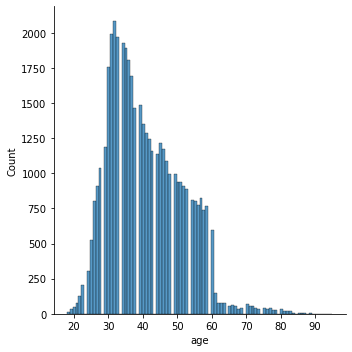

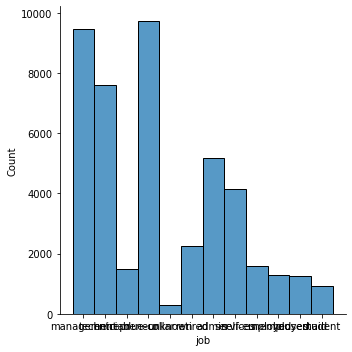

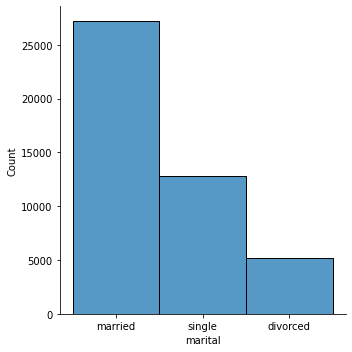

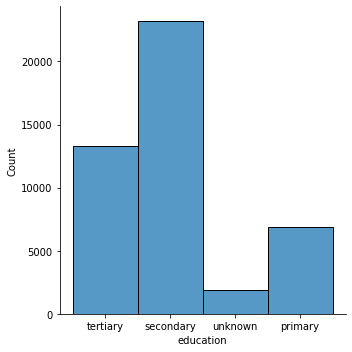

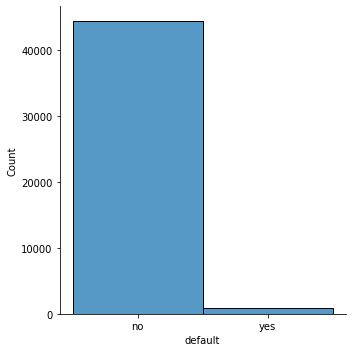

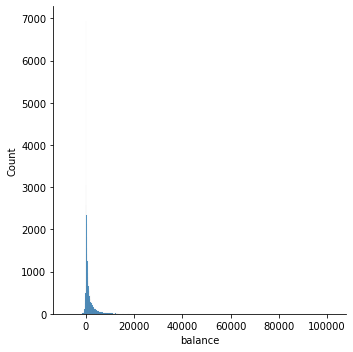

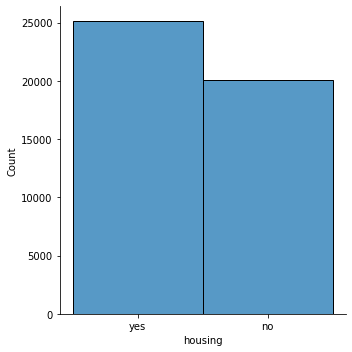

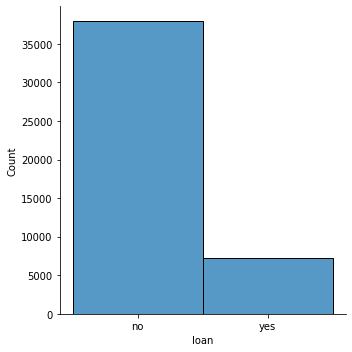

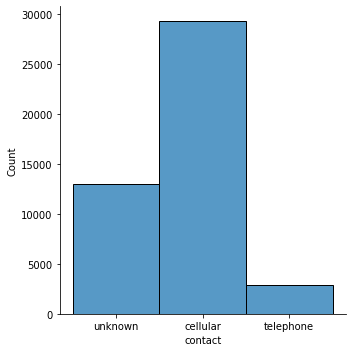

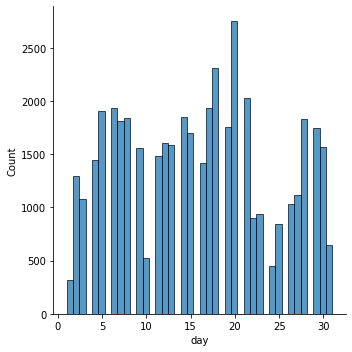

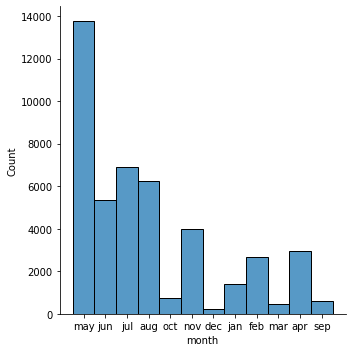

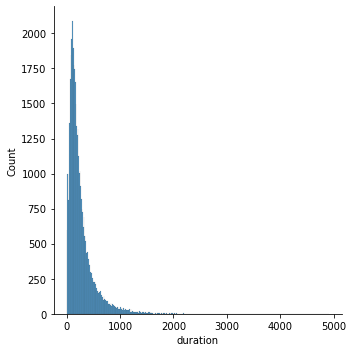

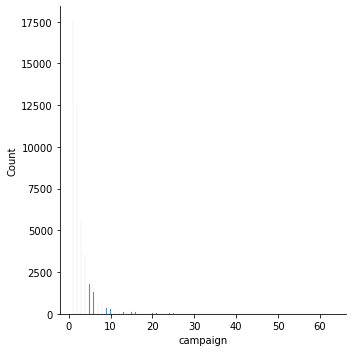

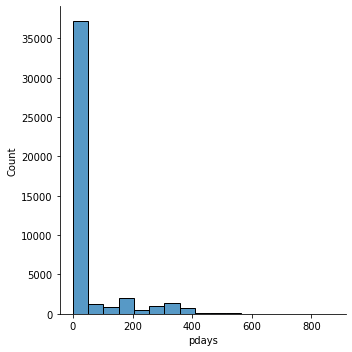

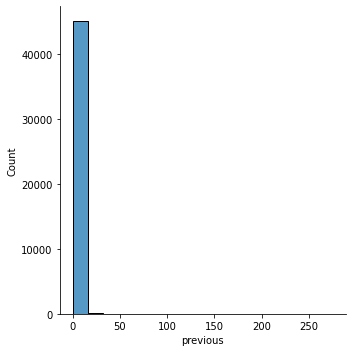

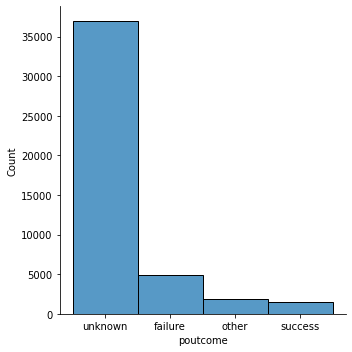

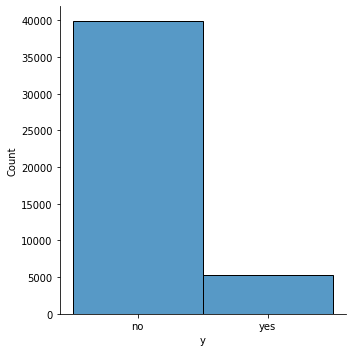

In [263]:
#Distplots (type gaussienne)
for each in df.columns:
    sns.displot(df[each])

In [264]:
#Vérification du nombre de données, si plusieurs données sont peu représentés (<3%) alors regrouper dans une seule et même catégorie
#??????????????????????????????
#pieChart avant/apres
df['job']
df_tmp = pd.DataFrame()
df_tmp['job'] = df['job']
df_tmp['count'] = df['job']
df_tmp = df_tmp.groupby(by='job').count()

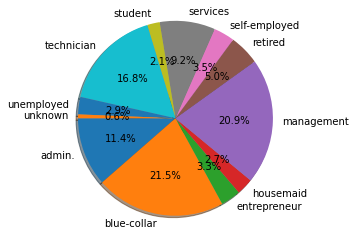

In [265]:
fig1, ax1 = plt.subplots()
ax1.pie(df_tmp['count'], labels=df_tmp.index, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

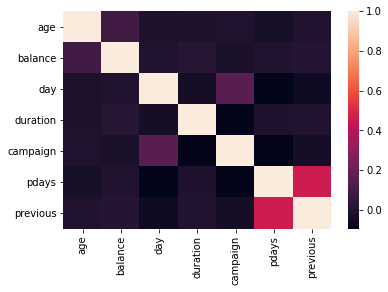

In [266]:
#Heatmap + observations sur les corrélations
sns.heatmap(df.corr())

In [267]:
#oneHot encoding en parler

cats = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
bools = ['default', 'housing', 'loan', 'y']

In [268]:
encoders = {}
for each in cats:
  le = LabelEncoder()
  le.fit(df[each])
  print('{}: {}'.format(each, le.classes_))
  df[each] = le.transform(df[each])
  #le.inverse_transform(df[each])
  encoders[each] = le

job: ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital: ['divorced' 'married' 'single']
education: ['primary' 'secondary' 'tertiary' 'unknown']
contact: ['cellular' 'telephone' 'unknown']
month: ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
poutcome: ['failure' 'other' 'success' 'unknown']


In [269]:
for each in bools:
  df[each] = df[each].apply(lambda x: 1 if x == 'yes' else 0)

In [270]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

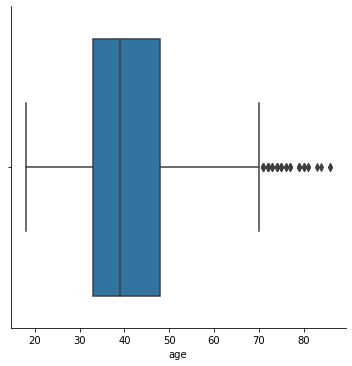

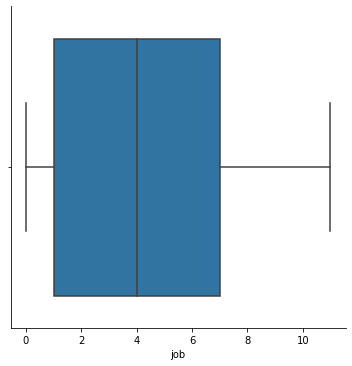

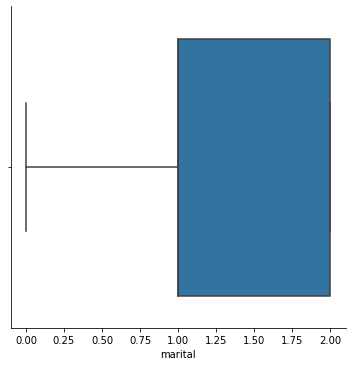

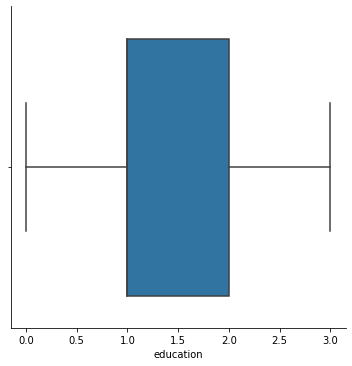

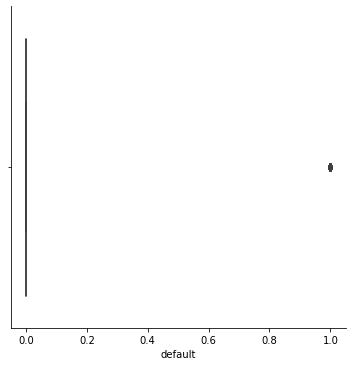

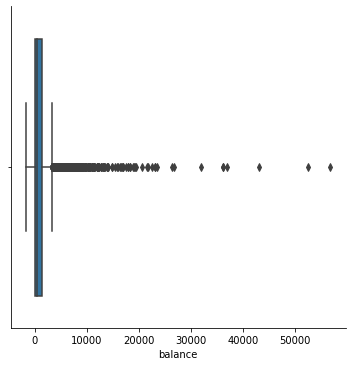

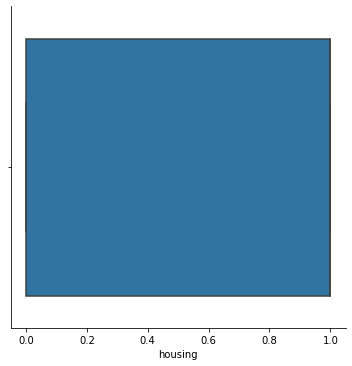

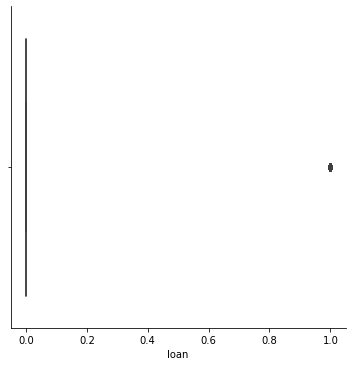

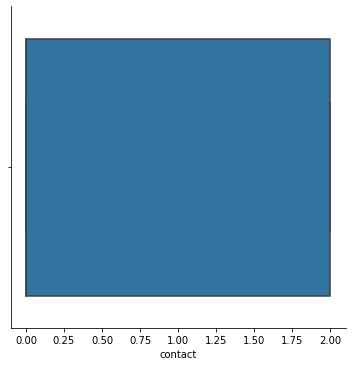

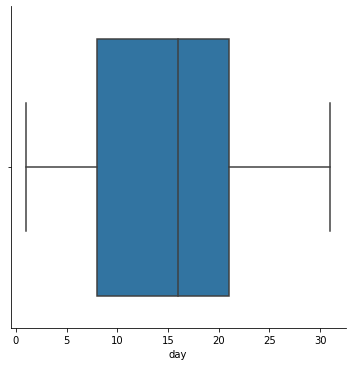

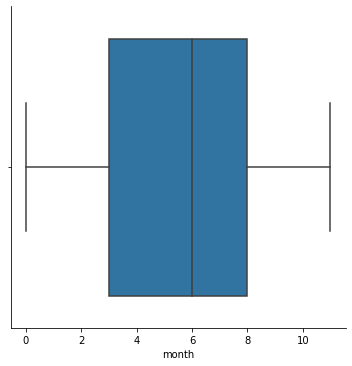

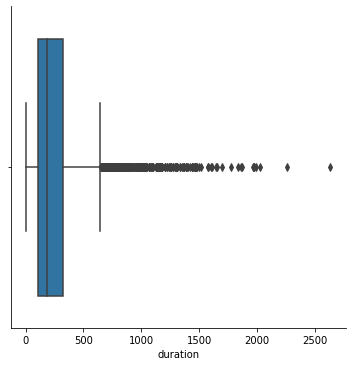

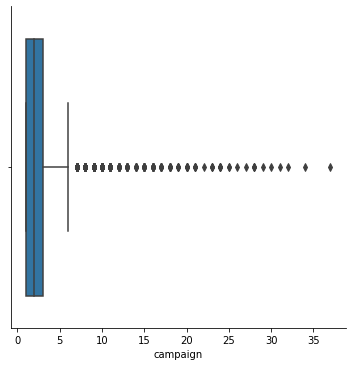

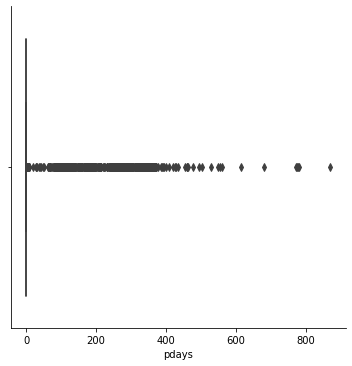

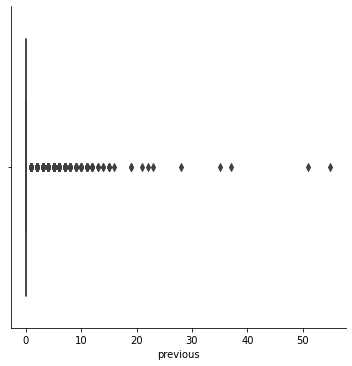

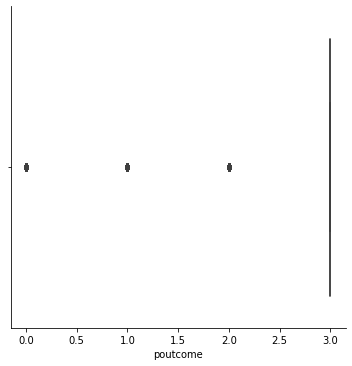

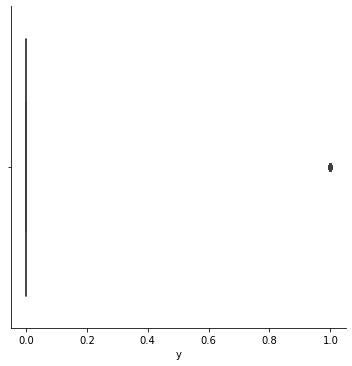

In [271]:
#Données extremes : boites a moustaches
for each in df.columns:
  g = sns.catplot(x=each, data=df.sample(5000), kind='box')

In [272]:
target = df['y']
features = df.copy().drop(columns=['y'])
features

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9,1,2,0,825,0,0,0,17,9,977,3,-1,0,3
45207,71,5,0,0,0,1729,0,0,0,17,9,456,2,-1,0,3
45208,72,5,1,1,0,5715,0,0,0,17,9,1127,5,184,3,2
45209,57,1,1,1,0,668,0,0,1,17,9,508,4,-1,0,3


In [273]:
#TTS
X_tr, X_te, Y_tr, Y_te = train_test_split(features, target)

In [274]:
#Pipeline LinearSVC #a faire pour KNN puis SVC selon le workflow
#pipeline_details = [('LinearSVC', LinearSVC())]
#pipeline = Pipeline(steps=pipeline_details)

pipeline_details = [('KNN', KNeighborsClassifier())]
pipeline = Pipeline(steps=pipeline_details)

#pipeline_details = [('SVC', SVC())]
#pipeline = Pipeline(steps=pipeline_details)

#pipeline_details = [('LR', LogisticRegression())]
#pipeline = Pipeline(steps=pipeline_details)

In [275]:
hyperparameters = {}
#hyperparameters['LinearSVC__loss'] = ['hinge', 'squared_hinge']
#hyperparameters['LinearSVC__max_iter'] = [2500]
#hyperparameters['LinearSVC__C'] = list(range(1, 10, 1))
#LinearSVC: tol ? C ? penalty ? class_weight ? max_iter ?

hyperparameters['KNN__n_neighbors'] = [i for i in range(1, 15 +1, 2)]

#hyperparameters['SVC__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

#hyperparameters['LR__C'] = list(range(1, 10, 1))
#hyperparameters['LR__max_iter'] = list(range(1000, 10001, 1000))

In [276]:
hyperparameter_search = GridSearchCV(pipeline,
                                     hyperparameters,
                                     scoring='accuracy',
                                     cv=5)
#scoring a developper

In [277]:
hyperparameter_search.fit(X_tr, Y_tr)

print('Meilleur score : {:.5f}'.format(hyperparameter_search.best_score_))
print('Meilleur paramètres : {}'.format(hyperparameter_search.best_params_))

Meilleur score : 0.88578
Meilleur paramètres : {'KNN__n_neighbors': 13}


In [278]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_tr, Y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [279]:
preds = knn.predict(X_te)
proba = knn.predict_proba(X_te)

In [280]:
result_df = pd.DataFrame(X_te)
result_df['Predictions'] = preds
for i in range(0, len(proba[0])):
  result_df['Probability'] = proba[:, (0 if preds[i] == 0 else 1)]
result_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Predictions,Probability
14028,26,4,1,2,0,17,0,1,0,11,5,522,1,-1,0,3,0,0.909091
36232,24,1,2,1,0,1,1,0,0,11,8,79,2,-1,0,3,0,0.909091
27021,50,0,1,1,0,4117,0,0,0,21,9,530,1,-1,0,3,0,0.545455
15708,32,0,2,1,0,64,1,0,0,21,5,204,3,-1,0,3,0,1.000000
33231,31,4,2,2,0,635,1,0,0,20,0,37,1,320,2,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6096,49,1,1,1,0,134,1,1,2,27,8,265,2,-1,0,3,0,1.000000
20789,32,9,2,1,0,136,1,0,0,13,1,144,2,-1,0,3,0,0.818182
36177,35,7,1,1,0,2048,1,0,0,11,8,219,1,173,2,0,0,0.545455
10066,50,4,1,2,0,396,0,0,2,11,6,62,2,-1,0,3,0,1.000000


Accuracy: 0.8878173936123153


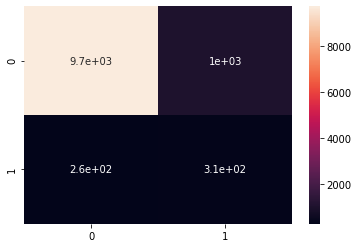

In [281]:
#Affichage des coefficients/ accuracy
def accuracy(p, y):
  return (p==y).sum()/len(y)

def show_cm(cm, labels):
    """show confusion matrix
    """
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

print('Accuracy: {}'.format(accuracy(preds, Y_te)))
show_cm(confusion_matrix(preds, Y_te, labels=[0, 1]), [0, 1])

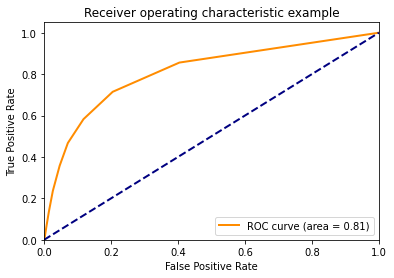

In [282]:
#n_classes
#Y_te
#proba
#regarder ravel()

n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_te, proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_te.ravel(), proba[:, i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


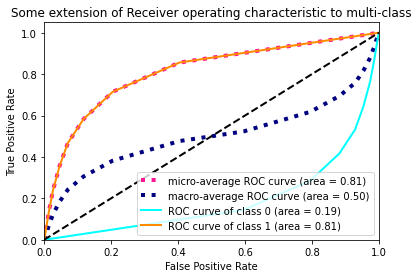

In [283]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


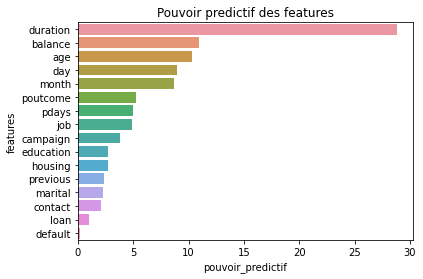

In [284]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_tr, Y_tr)
importances = rf.feature_importances_
d = pd.DataFrame()
d['features'] = X_tr.columns
d['pouvoir_predictif'] = importances
d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
d = d.sort_values(by='pouvoir_predictif', ascending=False)
sns.barplot(d['pouvoir_predictif'], d['features']).set_title('Pouvoir predictif des features');

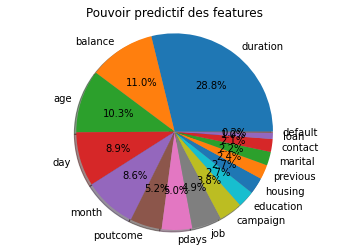

In [285]:
fig1, ax1 = plt.subplots()
ax1.pie(d['pouvoir_predictif'], labels=d['features'], autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pouvoir predictif des features')
plt.show()

In [286]:
#Sélection du meilleur paramétrage ==> GridSearchCV ? (si oui fait plus haut ..)

In [287]:
#Le model est-il en overfitting/underfitting/OK ?

In [288]:
#barplot features importance

In [289]:
#Autres affichages valorisés

In [290]:
#Affichage des metrics standard et commentaire sur la pertinence